# Natural Language Inference with SVM and SBERT & TF-IDF

This notebook combines the SVM model implementation with SBERT embeddings & TF-IDF for Natural Language Inference (NLI) tasks.

In [36]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re
import joblib
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
)

# nltk.data.path.append('/kaggle/input/nltk-data1/nltk_data')

## Data Preprocessing Class

Handles text cleaning and vectorization for classification tasks.

**Key Features:**
- `preprocess_text(text)`: Lowercases, removes noise, lemmatizes text.
- `vectorize_with_sentence_transformer(texts)`: Encodes using SBERT.
- `vectorize_with_tfidf(train, dev)`: TF-IDF encoding (1–3 grams, binary).
- `prepare_data(train_path, dev_path, method)`: Full pipeline including preprocessing and vectorization.

Currently supports the `'ensemble'` method combining SBERT and TF-IDF.


In [37]:
class DataPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.sbert_model = SentenceTransformer('all-MiniLM-L6-v2-local')


    def vectorize_with_sentence_transformer(self, texts):
        print("Vectorizing with SentenceTransformer...")
        return self.sbert_model.encode(texts, show_progress_bar=True)

        
    def preprocess_text(self, text):
        """Preprocess a single text string without removing stopwords"""
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
        text = re.sub(r'([.,!?])', r' \1 ', text)
        
        text = re.sub(r'\s+', ' ', text)
        tokens = word_tokenize(text)

        processed_tokens = []
        for token in tokens:
            if len(token) > 1:
                token = self.lemmatizer.lemmatize(token)
                processed_tokens.append(token)
        
        return ' '.join(processed_tokens)

    
    def vectorize_with_tfidf(self, train_texts, dev_texts):
        print("Vectorizing with TF-IDF (binary, unigrams + bigrams + trigrams)...")
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=15000,
            ngram_range=(1, 3),
            min_df=3,
            binary=True,
            stop_words=None  
        )
        X_train = self.tfidf_vectorizer.fit_transform(train_texts)
        X_dev = self.tfidf_vectorizer.transform(dev_texts)
        return X_train, X_dev

    
    def prepare_data(self, train_path, dev_path, method='word2vec'):
        print("Loading data...")
        train_df = pd.read_csv(train_path)
        dev_df = pd.read_csv(dev_path)

        print("Preprocessing original training data...")
        train_df['premise'] = train_df['premise'].apply(self.preprocess_text)
        train_df['hypothesis'] = train_df['hypothesis'].apply(self.preprocess_text)
        train_df['text'] = '[P] ' + train_df['premise'] + ' [H] ' + train_df['hypothesis']
    
        dev_df['premise'] = dev_df['premise'].apply(self.preprocess_text)
        dev_df['hypothesis'] = dev_df['hypothesis'].apply(self.preprocess_text)
        dev_df['text'] = '[P] ' + dev_df['premise'] + ' [H] ' + dev_df['hypothesis']
    
        print(f"Vectorizing texts using method: {method}")
    
        if method == 'ensemble':
            X_sbert_train = self.vectorize_with_sentence_transformer(train_df['text'])
            X_sbert_dev = self.vectorize_with_sentence_transformer(dev_df['text'])
    
            X_tfidf_train, X_tfidf_dev = self.vectorize_with_tfidf(train_df['text'], dev_df['text'])
    
            # Combine features
            X_train = np.concatenate([X_sbert_train, X_tfidf_train.toarray()], axis=1)
            X_dev = np.concatenate([X_sbert_dev, X_tfidf_dev.toarray()], axis=1)
    
        else:
            raise ValueError("Unsupported vectorization method.")

        return X_train, X_dev, train_df['label'].astype(int), dev_df['label'].astype(int)




## SVM Model Class

A wrapper for logistic regression used in classification tasks.  
Supports training, evaluation, prediction, and hyperparameter tuning using GridSearchCV.

**Key Methods:**
- `train(X, y)`: Fit the model.
- `evaluate(X, y)`: Print and return classification metrics.
- `tune_hyperparameters(X_train, y_train, X_dev, y_dev)`: Grid search for best `C`.
- `predict(X)`: Predict labels.
- `predict_proba(X)`: Predict probabilities.


In [38]:
class SVMModel:
    def __init__(self):

        self.model = LogisticRegression(
            C=0.1,
            class_weight='balanced',
            max_iter=1000,
            solver='liblinear'
        )

    
    def tune_hyperparameters(self, X_train, y_train, X_dev, y_dev):
        """Use GridSearchCV to tune LogisticRegression hyperparameters"""
        print("Tuning LogisticRegression hyperparameters...")
    
        param_grid = {
            'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
        }
    
        base_model = LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            solver='liblinear'
        )
    
        cv = StratifiedKFold(n_splits=3, shuffle=True)
    
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='accuracy',
            cv=cv,
            verbose=2,
            n_jobs=-1
        )
    
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"\nBest Parameters: {grid_search.best_params_}")
        self.model = best_model
        return self.evaluate(X_dev, y_dev)
        
    def train(self, X_train, y_train):
        """Train the SVM model"""
        print("Training SVM model...")
        self.model.fit(X_train, y_train)
        print("Training completed!")
        
    def evaluate(self, X_dev, y_dev):
        """Evaluate the model on development set with full baseline metrics"""
        print("\nEvaluating model on development set...")
        y_pred = self.model.predict(X_dev)
    
        # Calculate full metrics
        metrics = {
            "Accuracy": accuracy_score(y_dev, y_pred),
            "Macro-P": precision_score(y_dev, y_pred, average='macro'),
            "Macro-R": recall_score(y_dev, y_pred, average='macro'),
            "Macro-F1": f1_score(y_dev, y_pred, average='macro'),
            "W Macro-P": precision_score(y_dev, y_pred, average='weighted'),
            "W Macro-R": recall_score(y_dev, y_pred, average='weighted'),
            "W Macro-F1": f1_score(y_dev, y_pred, average='weighted'),
            "MCC": matthews_corrcoef(y_dev, y_pred)
        }
    
        # Print metrics
        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
        return metrics
    
    def predict(self, X):
        """Make predictions using the trained model"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Get probability estimates for the predictions"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        return self.model.predict_proba(X) 

## Model Training & Prediction Pipeline

Runs the full pipeline:

1. Initializes the preprocessor and model.
2. Loads and preprocesses training and dev data using the `ensemble` method (SBERT + TF-IDF).
3. Tunes hyperparameters via `GridSearchCV`.
4. Makes predictions on the dev set.
5. Saves predictions to `predictions.csv`.


In [39]:
preprocessor = DataPreprocessor()
model = SVMModel()

X_train, X_dev, y_train, y_dev = preprocessor.prepare_data(
    'data/training_data/NLI/train.csv',
    'data/training_data/NLI/dev.csv',
    method='ensemble'
)


results = model.tune_hyperparameters(X_train, y_train, X_dev, y_dev)

y_pred = model.predict(X_dev)


# Save Model
joblib.dump({'model': model.model, 'tfidf_vectorizer': preprocessor.tfidf_vectorizer}, '../Test/Models/svm_model.joblib')
print("Model saved to svm_model.joblib")

pd.DataFrame({"prediction": y_pred}).to_csv("predictions.csv", index=False)
print("predictions.csv with header has been saved.")




Loading data...
Preprocessing original training data...
Vectorizing texts using method: ensemble
Vectorizing with SentenceTransformer...


Batches: 100%|██████████| 764/764 [00:35<00:00, 21.50it/s]


Vectorizing with SentenceTransformer...


Batches: 100%|██████████| 211/211 [00:09<00:00, 21.83it/s]


Vectorizing with TF-IDF (binary, unigrams + bigrams + trigrams)...
Tuning LogisticRegression hyperparameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


python(82518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(82519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(82520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forke

[CV] END .............................................C=0.01; total time=  33.2s
[CV] END .............................................C=0.01; total time=  33.3s
[CV] END .............................................C=0.01; total time=  33.4s
[CV] END ..............................................C=0.1; total time=  33.4s
[CV] END ..............................................C=0.1; total time=  33.6s
[CV] END ..............................................C=0.1; total time=  33.6s
[CV] END ..............................................C=0.5; total time=  33.9s
[CV] END ..............................................C=0.5; total time=  34.0s
[CV] END ..............................................C=0.5; total time=  33.5s
[CV] END ..............................................C=1.0; total time=  34.8s
[CV] END ..............................................C=1.0; total time=  34.7s
[CV] END ..............................................C=1.0; total time=  34.9s
[CV] END ...................

## Performance Comparison Plot

Compares the model's performance metrics against the baseline.

- Metrics: Accuracy, Macro/Weighted Precision, Recall, F1, and MCC.
- Bars show baseline vs. the trained SVM model (SBERT + TF-IDF).
- Annotates exact values on top of each bar for clarity.


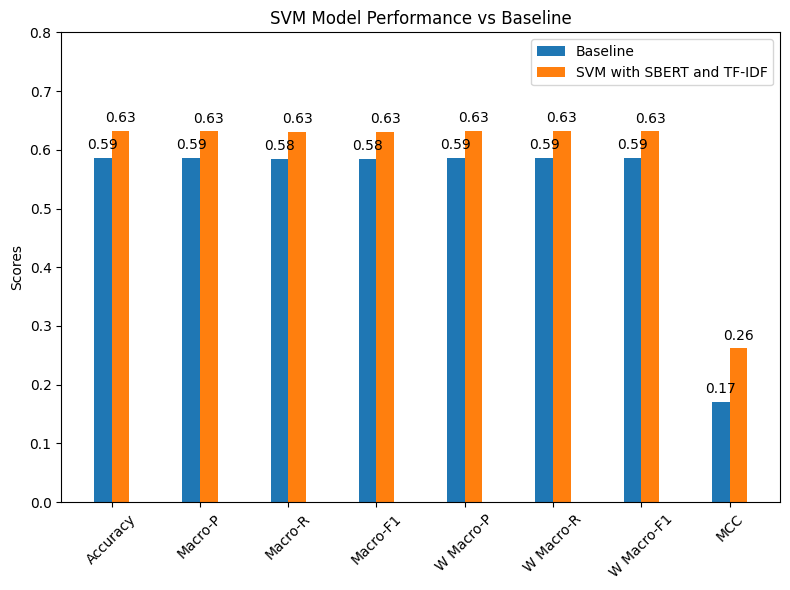

In [40]:
# Baseline results from the poster
baseline_scores = {
    "Accuracy": 0.5863,
    "Macro-P": 0.5855,
    "Macro-R": 0.5848,
    "Macro-F1": 0.5846,
    "W Macro-P": 0.5857,
    "W Macro-R": 0.5863,
    "W Macro-F1": 0.5854,
    "MCC": 0.1703
}

your_scores = {
    "Accuracy": results["Accuracy"],
    "Macro-P": results["Macro-P"],
    "Macro-R": results["Macro-R"],
    "Macro-F1": results["Macro-F1"],
    "W Macro-P": results["W Macro-P"],
    "W Macro-R": results["W Macro-R"],
    "W Macro-F1": results["W Macro-F1"],
    "MCC": results["MCC"]
}


# Plotting
labels = list(baseline_scores.keys())
baseline_values = [baseline_scores[key] for key in labels]
your_values = [your_scores[key] for key in labels]

x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline')
bars2 = ax.bar(x + width/2, your_values, width, label='SVM with SBERT and TF-IDF')

ax.set_ylabel('Scores')
ax.set_title('SVM Model Performance vs Baseline')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.set_ylim(0, 0.8)

# Add values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
